In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Chargement des données

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
avec_etoile = 0

In [5]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[avec_etoile]
data_Y = data_Y[avec_etoile]

## Liste des colonnes utilisables

In [6]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

# Prédiction simple

Pas de sélection, juste pour observer différents algos en CV (dont leur stabilité)

In [7]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

In [8]:
def launch_kfold(model, X, y, splits=8, silence=False):
    kf = KFold(n_splits=splits)
    score_final = {'R2':0, 'RMSE':0, 'MAE':0}
    
    donnees_min = {'R2':1, 'iloc':None, 'pred':None}
    donnees_max = {'R2':-1, 'iloc':None, 'pred':None}

    for train, test in kf.split(X):
        # Entraînement
        model.fit(X.iloc[train], y.iloc[train])

        # Prédiction sur le jeu de test
        y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        # Evaluate
        score = metrics.r2_score(y_test, y_pred)
        if not silence:
            print('R2 : ', score)
        score_final['R2'] += abs(score)
        
        if score < donnees_min['R2']:
            donnees_min['R2'] = score
            donnees_min['iloc'] = test.copy()
            donnees_min['pred'] = y_pred.copy()
        
        if score > donnees_max['R2']:
            donnees_max['R2'] = score
            donnees_max['iloc'] = test.copy()
            donnees_max['pred'] = y_pred.copy()

        score = metrics.mean_squared_error(y_test, y_pred, squared=True)
        score_final['RMSE'] += score

        score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
        score_final['MAE'] += score

    if not silence:
        for k, score in score_final.items():
            print('Score {} final : {}'.format(k, score/kf.get_n_splits()))
    
    return donnees_max, donnees_min

### Partie pour detecter les outliers réguliers
aka les lignes qui ne sont jamais bien prédites

In [9]:
def get_outliers(data_test, data_pred, outliers={}, step=0, limit=20):
    data_pred = pd.Series(data_pred, index=data_test.index).rename('Pred')

    compare_result = pd.concat([data_test.rename('Test'), data_pred], axis=1)
    compare_result['Diff'] = (compare_result['Test'] - compare_result['Pred']).abs()
    compare_result = compare_result.sort_values(by='Diff', ascending=False)
    
    for i in compare_result.head(limit).index:
        if i not in outliers:
            outliers[i] = 1-step
        else:
            outliers[i] += 1-step
    
    return outliers

In [10]:
outliers = {}

In [11]:
'''
for _ in range(50):
    idx = np.random.permutation(data_X.index)
    data_X = data_X.reindex(idx)
    data_Y = data_Y.reindex(idx)

    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)
    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)
    print(donnees_min['R2'])
    if donnees_min['R2'] < 0.6 :
        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)
'''

"\nfor _ in range(50):\n    idx = np.random.permutation(data_X.index)\n    data_X = data_X.reindex(idx)\n    data_Y = data_Y.reindex(idx)\n\n    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)\n    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)\n    print(donnees_min['R2'])\n    if donnees_min['R2'] < 0.6 :\n        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)\n"

In [12]:
# pd.DataFrame(outliers.items()).sort_values(by=1, ascending=False).head(20)

Suppression de ces valeurs

In [13]:
for i in []:#[601, 1817, 1000, 1027, 3206, 2896, 3171, 3373, 550, 426]:
    data_X = data_X.drop(index=i)
    data_Y = data_Y.drop(index=i)

## Test de différents regressors

In [14]:
print('KFold avec DummyRegressor :')
dum = dummy.DummyRegressor(strategy='median')
launch_kfold(dum, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec Lasso :')
regr = MultiTaskLassoCV(cv=5)
launch_kfold(regr, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec XGBoost :')
xgbreg = XGBRegressor()
launch_kfold(xgbreg, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec RandomForest :')
regr = RandomForestRegressor(max_depth=50)
donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y)

KFold avec DummyRegressor :
R2 :  -0.025235674892880144
R2 :  -0.0034547160791155163
R2 :  -0.00040963314851616417
R2 :  -0.002422098037897502
R2 :  -0.015139620543655363
R2 :  -0.011004689556220582
R2 :  -0.020479870596697647
R2 :  -0.00010344084557378785
Score R2 final : 0.009781217962569588
Score RMSE final : 1.8729235529899597
Score MAE final : 1.0805736243497104



 KFold avec Lasso :
R2 :  0.7339278324014163
R2 :  0.6872884276706632
R2 :  0.6995646959594977
R2 :  0.7257714648048427
R2 :  0.5998438022004411
R2 :  0.6669594354137651
R2 :  0.720839428612593
R2 :  0.7022092765292227
Score R2 final : 0.6920505454490552
Score RMSE final : 0.5774546635523005
Score MAE final : 0.575985109192137



 KFold avec XGBoost :
R2 :  0.7616478497088222
R2 :  0.7266659610611008
R2 :  0.7124152213975983
R2 :  0.7252652130899844
R2 :  0.62669778579858
R2 :  0.7304970189787904
R2 :  0.7193148630687112
R2 :  0.685121404949053
Score R2 final : 0.7109531647565801
Score RMSE final : 0.5420410484075546
Sc

## Affichage des features importance

In [15]:
def get_features_importance(model, X, y, plot=False):
    model.fit(X, y)
    importance = model.feature_importances_

    list_col = X.columns.to_list()
    list_features = []
    for i, v in pd.Series(importance).sort_values(ascending=False).items():
        list_features.append([list_col[i],v])
    
    list_features = pd.DataFrame(list_features, columns=['Nom', 'Value'])
    
    if plot:
        list_features.head(20).plot.barh(x='Nom', y='Value', figsize=(7,7))
    
    return list_features

,Nom,Value
0,PropertyGFATotal,0.119543
1,Type_Self-storage facility,0.094479
2,Type_Supermarket/grocery store,0.072667
3,Type_Restaurant,0.048181
4,Type_Worship facility,0.043298
5,CouncilDistrictCode_1,0.042232
6,Type_Fitness center/health club/gym,0.038313
7,Type_Laboratory,0.038022
8,Type_Data center,0.037177
9,Type_Distribution center,0.031183


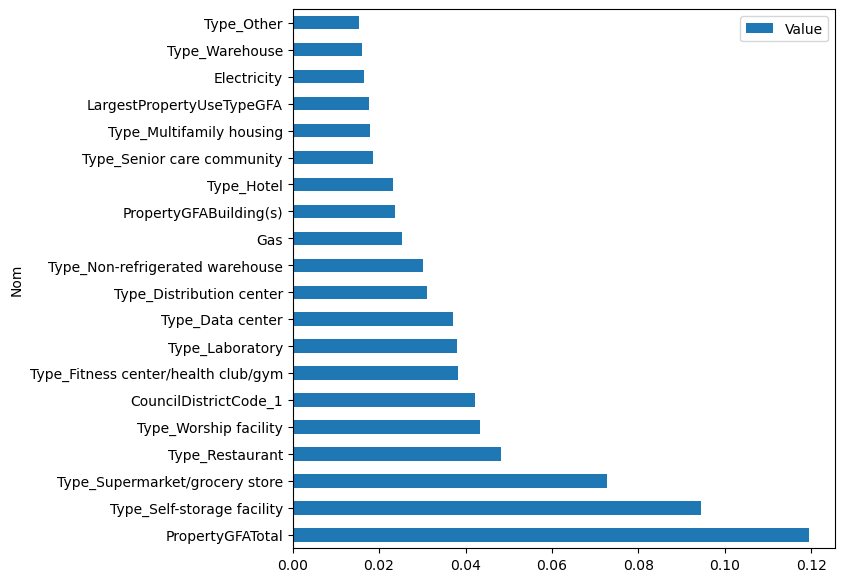

In [16]:
model = RandomForestRegressor(max_depth=30)
model = XGBRegressor()

get_features_importance(model, data_X[col_num], data_Y['Energy_Y'], True)

# GridSearch sur plusieurs algos

In [17]:
TARGET = 'Energy_Y' #'Energy_Y', 'CO2_Y'

In [18]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [19]:
# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15],
            "max_depth": [3, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y[TARGET], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0            0.0         0.003126      -0.00908
1            0.0         0.000000      -0.01880
Temps d'entrainement :  0.0
Temps de prédiction :  0.0031255245208740234
Score R2 : -0.0091 Deviation : 0.0133
Score RMSE : 1.2848 Deviation : 0.0480
Score MAE : 1.0321 Deviation : 0.0482

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0057
Score RMSE : 1.3030
Score MAE : 1.0498





 KNeighborsRegressor(n_neighbors=15, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.003933         0.093297      0.615005
1       0.009649         0.080641      0.619646
2       0.005637         0.084731      0.624524
3       0.004017         0.098508      0.615758
Temps d'entrainement :  0.005636978149414063
Temps de prédiction :  0.08473062515258789
Score R2 : 0.6245 Deviation : 0.0252
Score RMSE : 0.7837 Deviation : 0.0462
Score MAE : 0.5908 Deviation

Score MAE : 0.5009
Le meilleur modèle est: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


## Analyse et comparaison des algos
avec les meilleurs hypermarametres sélectionnés

In [20]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [21]:
from sklearn.ensemble import VotingRegressor

tmp_reg = []
for e in list_models:
    if e['name'] in ['BayesianRidge', 'LassoCV', 'XGBRegressor']:
        tmp_reg.append((e['name'], e['clf']))

reg = VotingRegressor(estimators=tmp_reg)
list_models.append({'name':'Voting-Bay-Lasso-XGB', 'clf':reg})

name
DummyRegressor           0.000000
LinearRegression         0.510163
Lasso                    0.641422
KNeighborsRegressor      0.648010
Ridge                    0.713674
BayesianRidge            0.717250
LassoCV                  0.723239
RandomForestRegressor    0.723911
Voting-Bay-Lasso-XGB     0.740403
XGBRegressor             0.754528
Name: test_accuracy, dtype: float64


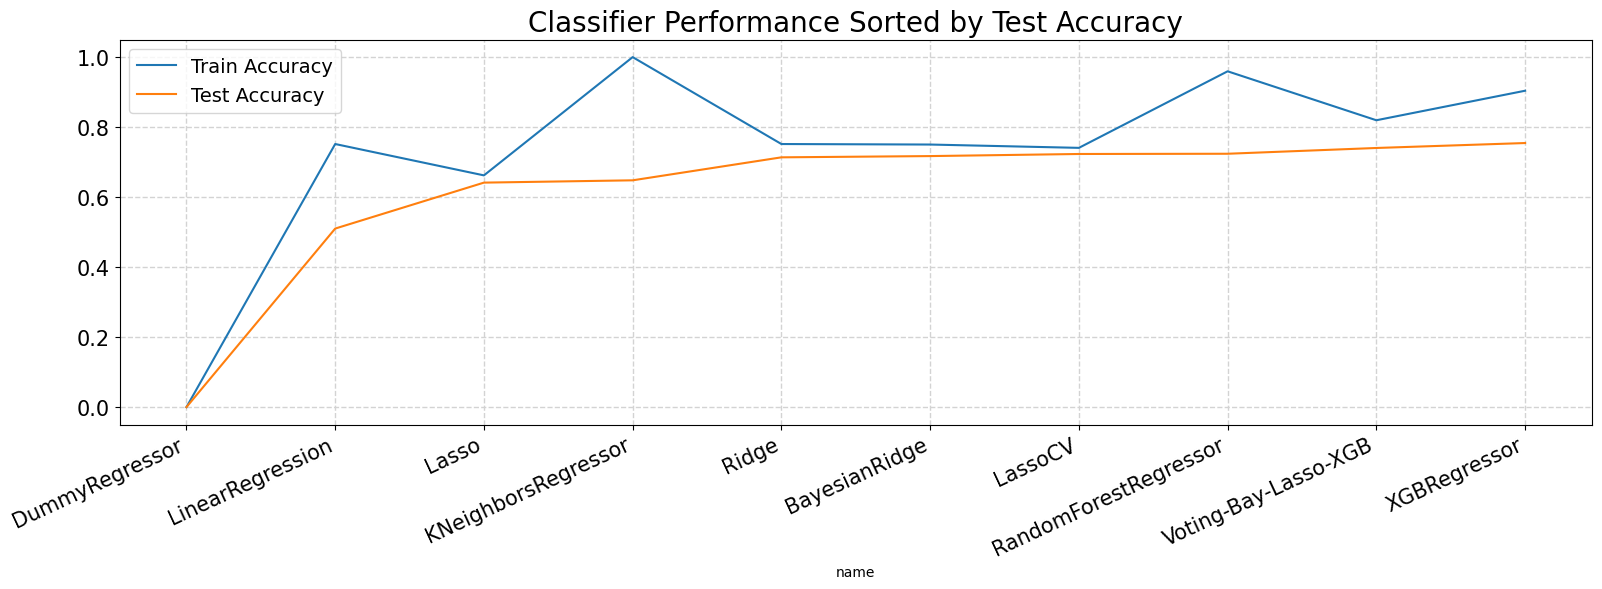

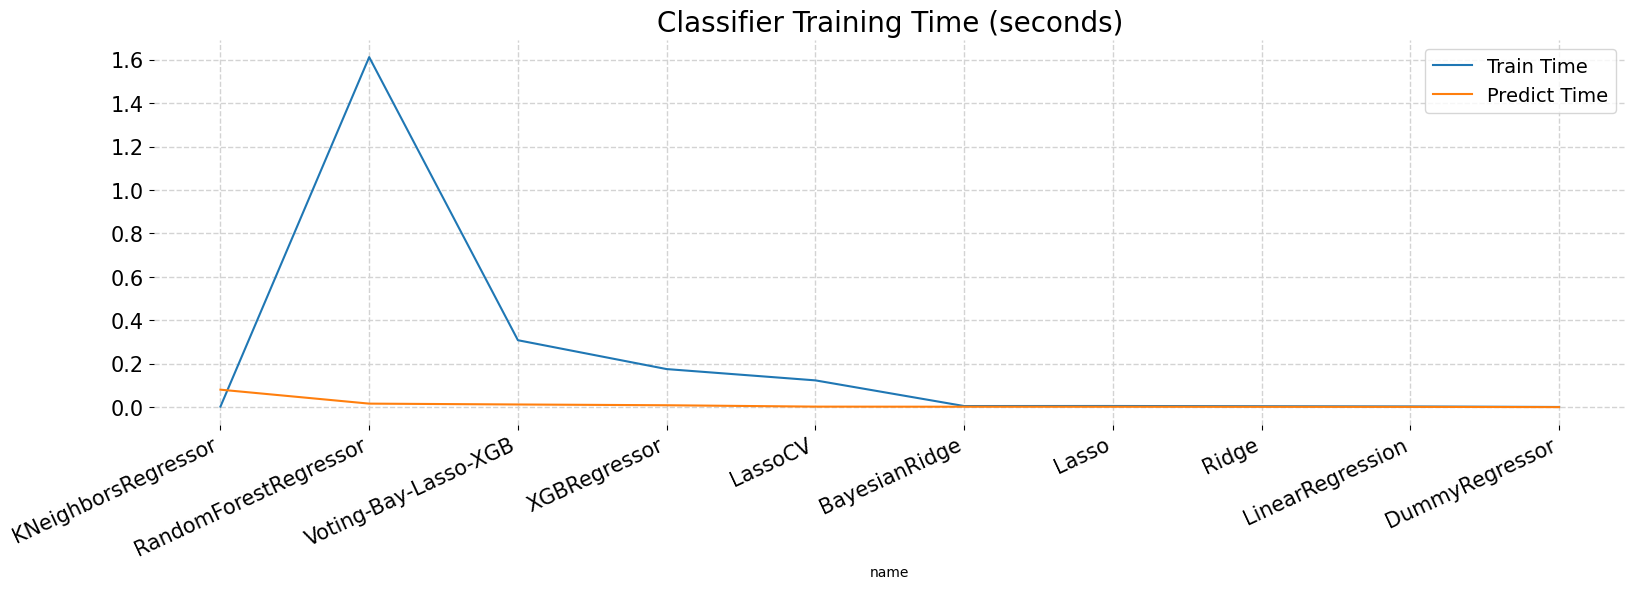

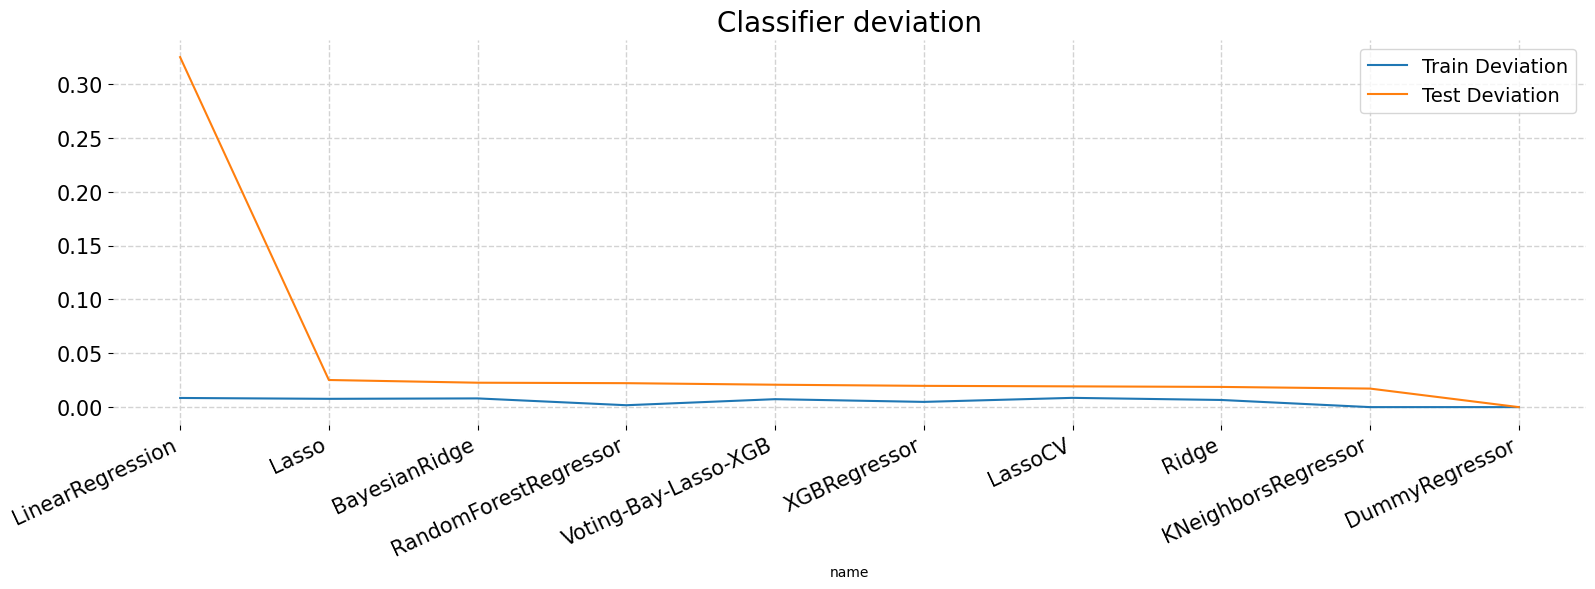

In [22]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    #mask_non_res = X_test[['BuildingType_Nonresidential', 'BuildingType_Nonresidential cos', 'BuildingType_Nonresidential wa']].sum(axis=1) == 1
    #X_test = X_test.loc[mask_non_res]
    #y_test = y_test.loc[mask_non_res]

    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    test_score = max(test_score, 0)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    train_score = max(train_score, 0)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*25:
    model_details = train_model(model, data_X[col_num], data_Y[TARGET]) 
    trained_models.append(model_details)


    
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True)
print(model_df["test_accuracy"])
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
#plt.xticks(rotation=90)

model_df.sort_values("predict_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False) 

In [23]:
import shap

In [24]:
shap.initjs()

In [25]:
shap_model = BayesianRidge(alpha_init=1, lambda_init=0.1)#LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y[TARGET])

explainer = shap.Explainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [26]:
#shap_model = XGBRegressor().fit(data_X[col_num], data_Y[TARGET])

In [27]:
#explainer = shap.Explainer(shap_model, feature_names=col_num)
#shap_values = explainer.shap_values(data_X[col_num])

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

In [29]:
#shap.plots.waterfall(shap_values[0])

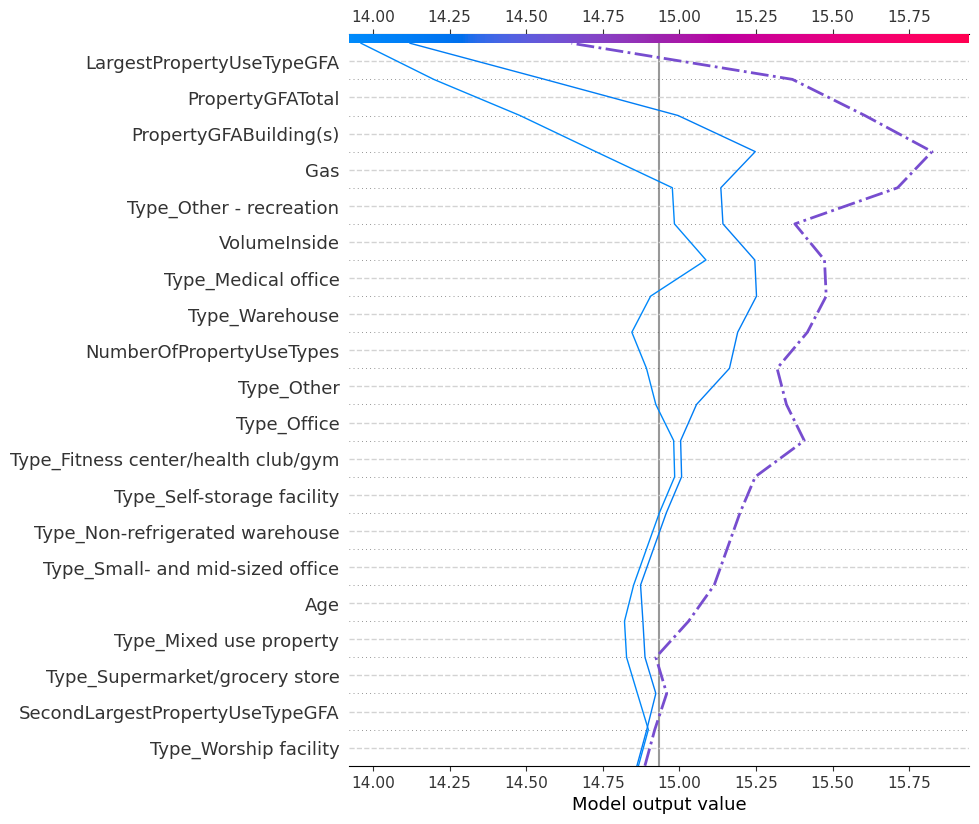

In [30]:
shap.decision_plot(explainer.expected_value, shap_values[0:3], col_num, highlight=0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


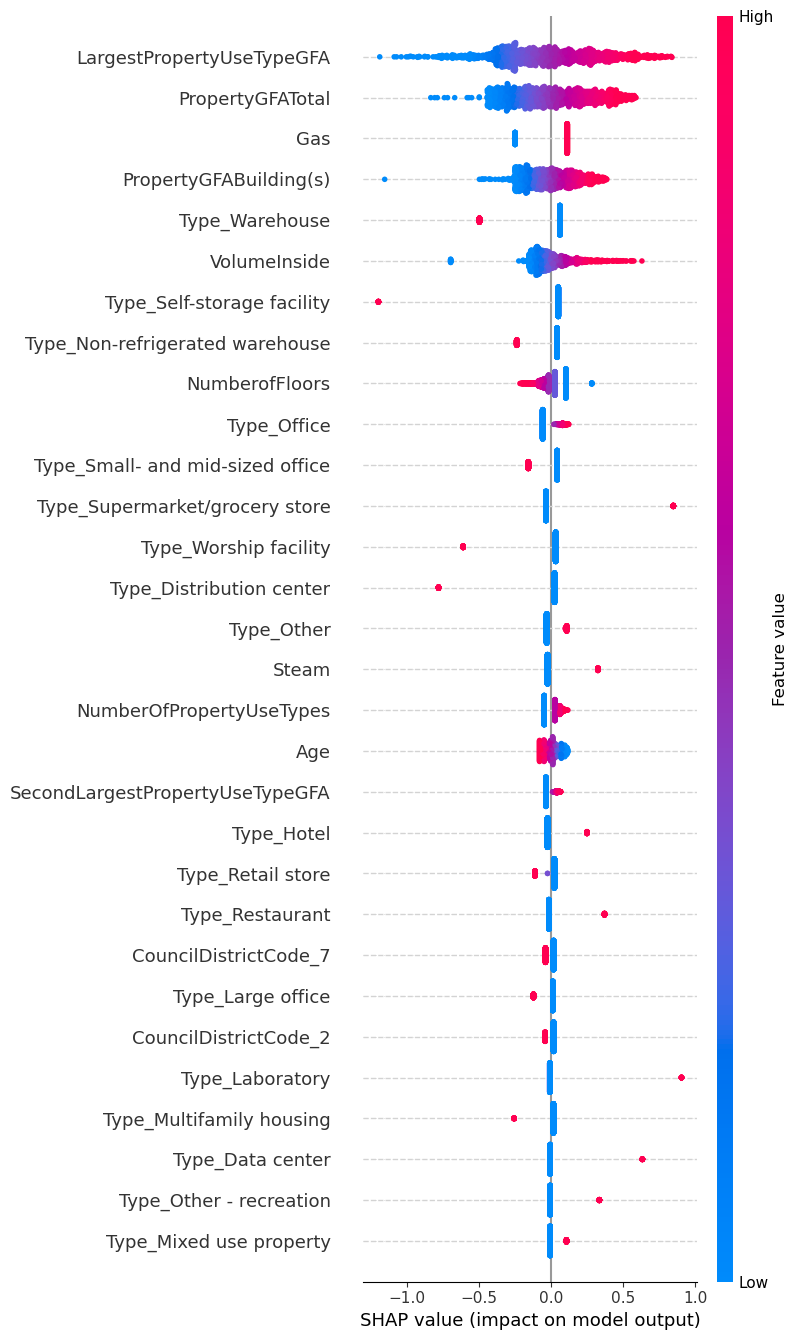

In [31]:
shap.summary_plot(shap_values, data_X[col_num], max_display=30)

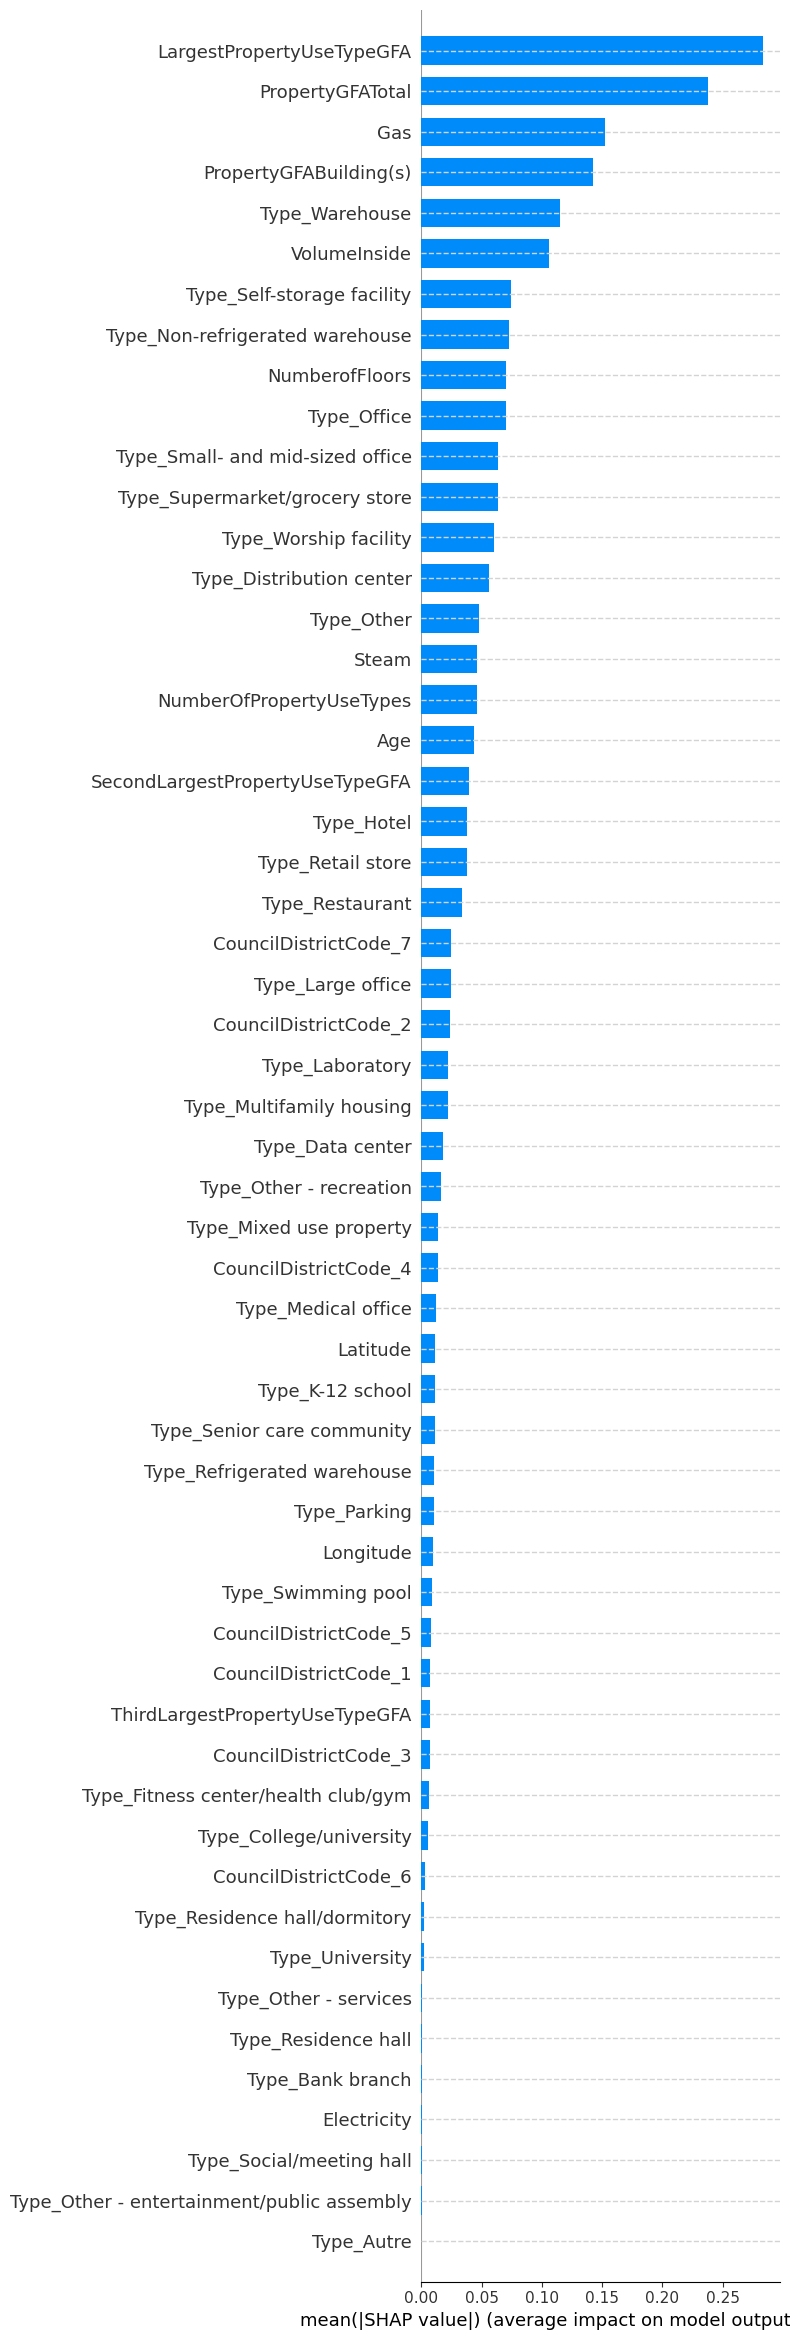

In [32]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=300)

In [33]:
output = 'Energy_Y'
algo = 'bay'
etoile = 'etoile' if avec_etoile == 1 else ''

In [34]:
y_hist = pd.DataFrame(columns=['Test', 'Predict'])

In [35]:
kf = KFold(n_splits=8)

for train, test in kf.split(data_X):
    X_train, y_train = data_X[col_num].iloc[train], data_Y[output].iloc[train]
    X_test, y_test = data_X[col_num].iloc[test], data_Y[output].iloc[test]
    
    model = BayesianRidge(alpha_init=1, lambda_init=0.1)
    if algo == 'XGB':
        model = XGBRegressor()
    model.fit(X_train, y_train)
    y_predict = pd.Series(model.predict(X_test), index=y_test.index)
    
    y_hist_tmp = pd.concat([y_test, y_predict], axis=1)
    y_hist_tmp.columns=['Test', 'Predict']
    
    y_hist = pd.concat([y_hist, y_hist_tmp])

In [36]:
y_hist['Diff'] = np.log(np.abs(np.exp(y_hist['Test'])-np.exp(y_hist['Predict'])))

In [37]:
y_hist

,Test,Predict,Diff
2782,14.611945,14.661533,11.632826
1470,13.818502,13.977628,12.061061
1620,14.367092,14.144381,12.755922
2804,14.074397,14.195983,12.028676
2687,14.477569,14.526931,11.493781
...,...,...,...
428,15.680494,15.865641,14.087890
2830,14.093949,13.479903,13.314903
1473,14.047919,14.217996,12.362654
1111,14.349379,13.985058,13.163021


In [38]:
import seaborn as sns

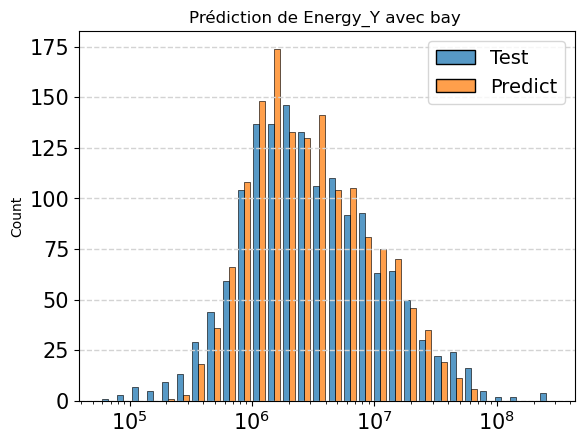

In [39]:
ax = sns.histplot(np.exp(y_hist[['Test', 'Predict']]), multiple="dodge", shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Prédiction de {} avec {} {}".format(output, algo, 'et Etoile' if etoile != '' else etoile))

fig = ax.get_figure()
fig.savefig("./data/graph/predict_{}_{}_{}.png".format(output, algo, etoile)) 

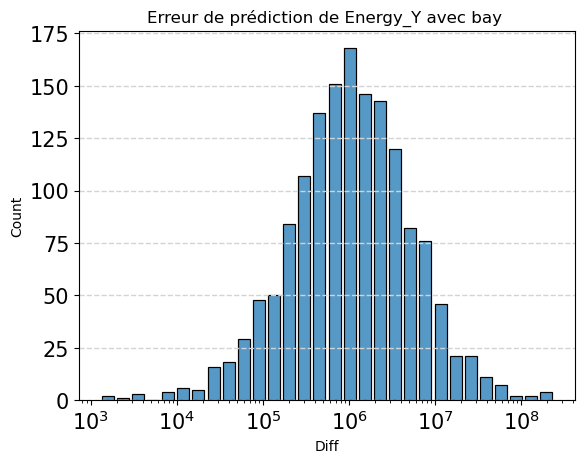

In [40]:
ax = sns.histplot(np.exp(y_hist['Diff']), shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Erreur de prédiction de {} avec {} {}".format(output, algo, 'et Etoile' if etoile != '' else etoile))

fig = ax.get_figure()
fig.savefig("./data/graph/erreur_{}_{}_{}.png".format(output, algo, etoile)) 

<AxesSubplot: xlabel='Test', ylabel='Predict'>

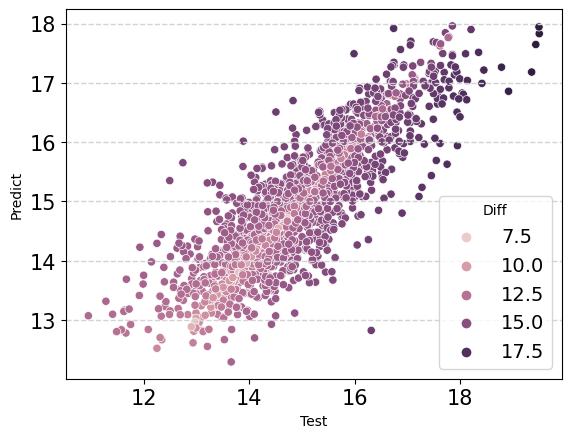

In [41]:
sns.scatterplot(y_hist, x='Test', y='Predict', hue='Diff')

In [42]:
annee_tranform = [(i, i*0.0334408 - 2.2) for i in range(0, 200, 5)]

In [43]:
model = BayesianRidge(alpha_init=1, lambda_init=0.1)
model.fit(data_X[col_num], data_Y['CO2_Y'])

BayesianRidge(alpha_init=1, lambda_init=0.1)

In [44]:
data_X_modif = data_X.loc[[1], col_num]

In [45]:
data_X.loc[[1], 'Age']

1   -1.058339
Name: Age, dtype: float64

In [46]:
for i, i_pt in annee_tranform:
    data_X_modif_tmp = data_X_modif.copy()
    data_X_modif_tmp['Age'] = i_pt
    print(i, np.exp(model.predict(data_X_modif_tmp)[0]))

0 338.97906142854214
5 339.0055385807313
10 339.03201780101153
15 339.05849908954445
20 339.0849824464916
25 339.1114678720145
30 339.1379553662747
35 339.16444492943384
40 339.19093656165353
45 339.21743026309537
50 339.24392603392096
55 339.27042387429196
60 339.29692378437
65 339.3234257643167
70 339.34992981429383
75 339.376435934463
80 339.402944124986
85 339.4294543860244
90 339.45596671774007
95 339.48248112029466
100 339.50899759385
105 339.5355161385677
110 339.5620367546094
115 339.58855944213735
120 339.6150842013132
125 339.64161103229867
130 339.66813993525557
135 339.6946709103458
140 339.7212039577312
145 339.74773907757356
150 339.7742762700348
155 339.80081553527685
160 339.8273568734616
165 339.8539002847509
170 339.8804457693068
175 339.9069933272911
180 339.9335429588658
185 339.96009466419264
190 339.98664844343415
195 340.01320429675195


In [47]:
np.exp(data_Y.loc[[1]])

,Energy_Y,CO2_Y
1,8387932.5,296.860016
